# Programming assignment 5: spotting cars using convolutional neural networks

**Goup 15:**
*Neha Devi Shakya, Sarvesh Meenowa, Khushi Chitra Uday*

In this assignment, we will see a few different approaches to building image classifiers using convolutional neural networks.

We have a small image dataset and our task is to train a CNN that can find images that contain cars. CNNs are data-hungry in general and we won't get a fantastic accuracy using this dataset, so as an alternative we'll explore the opportunity to "piggyback" on a pre-trained CNN model for another image classification task.

Purposes of this assignment:

practicing the use of the Keras library for neural network development;
getting some practical experience of working with image data and CNNs;
investigating overfitting in CNNs;
learning how to improve your CNN using data augmentation and transfer learning tricks.
Work in a group up of two or three people. You should submit a single Jupyter notebook including your code and comments as Markdown boxes.

Before submitting, please make sure that:

the names of all members of the group are listed at the beginning of the notebook;
all intermediate steps, results, and your conclusions are described carefully;
the code can be executed in one go without crashing or errors. If you use a notebook, please select Restart & Run All in the Kernel menu before you submit;
Submit the files at the submission page in Canvas.

## Preliminaries

* Repeat the lectures (or at least the notebooks) about neural network basics and convolutional neural networks.
* Make sure that Keras is installed. You can install by entering `conda install tensorflow` if using Anaconda. (The most recent version of Keras is bundled with the TensorFlow library.)
* If you are installing via pip/pip3 rather than Anaconda, you will need to install `h5py` as well, if you'd like to be able to save your trained models.
* Install the image processing library Pillow, which is needed by the Keras functions that load the images. (`conda install pillow` or `pip3 install Pillow`)

In [1]:
import numpy as np
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras import applications
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import decode_predictions, preprocess_input
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
# from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt
# set font size
plt.rcParams["font.size"] = 22
from tensorflow.keras.preprocessing.image import img_to_array, load_img

## Introduction: Loading images from a directory


 this section, we'll see how we can a set of images stored in a directory. Your work here does not need to be included in the report.

First download the package containing the images [here](https://chalmers.instructure.com/files/2151328/download?download_frd=1) and unpack it. These images have been extracted from a dataset included in the [PASCAL Visual Object Classes Challenge 2010](https://chalmers.instructure.com/files/2151328/download?download_frd=1) (VOC2010).

The structure of the directory is

* a5_images
  * train
    * car [800 images]
    * other [800 images]
  * validation
    * car [288 images]
    * other [288 images]

so as you can see, the images have already been split into a training and a validation set, and each subset contains a separate directory for each of the two classes (`car` and `other`). The class `other` contains images of various objects.

Keras includes a function `load_img` to load a single image, but we'll use a more practical approach for this assignment.

We first declare an `ImageDataGenerator`. This is an object that defines how images should be converted into NumPy data. In our case, we add a parameter `rescale`; this means that the color values range from 0 to 1 instead of 0 to 255. (This transformation is similar to a scaler in scikit-learn and has a similar purpose.)

In [2]:
data_gen = ImageDataGenerator(rescale = 1.0 / 255)

Now, let's read the images in the training set. By calling `flow_from_director`, we apply the `ImageDataGenerator` to transform the images stored in a directory. This will return a generator object that loads images, transforms them, and returns them in batches of a given size.

The parameters used here are:

* the location of the training images;
* `target_size` is for the size of the images: in our case, we'll resize them so that they are all 64x64 pixels;
* `batch_size` refers to the batch size we'll use when training;
* `class_mode='binary'` means that we'll treat the learning problem as a binary classification problem;
* `classes` is provided to make sure that `other` is coded as 0 and `car` as 1;
* `seed` is an arbitrary integer that initializes the random number generator for reproducibility;
* `shuffle` because we'd like the images to appear in a random order when training.

If you have a severe performance problem, you can resize the images to some size smaller than 64x64. This is likely to give you a slightly lower classification accuracy. (Conversely, if you have a high-end machine, you may consider increasing the image size.

In [ ]:
import zipfile
with zipfile.ZipFile("data/a5_images.zip", 'r') as zip_ref:
    zip_ref.extractall("data/")

In [3]:
imgdir = "data/a5_images" # or wherever you put them...
img_size = 64
batch_size = 32

In [4]:
train_generator = data_gen.flow_from_directory(
        f"{imgdir}/train", 
        target_size = (img_size, img_size), 
        batch_size = batch_size, 
        class_mode = "binary", 
        classes = ["other", "car"], 
        seed = 12345, 
        shuffle = True
)

Found 1600 images belonging to 2 classes.


In [5]:
validation_generator = data_gen.flow_from_directory(
        f"{imgdir}/validation", 
        target_size = (img_size, img_size), 
        batch_size = batch_size, 
        class_mode = "binary", 
        classes = ["other", "car"], 
        seed = 12345, 
        shuffle = True
)

Found 576 images belonging to 2 classes.


We'll take a look at a few images. We first read one batch from the generator. This will return a part of the training data: some images, and the corresponding labels (0 for `other`, 1 for `car`).

In [6]:
Xbatch, Ybatch = train_generator.next()

What is the form of the images in the batch? We take a look at the NumPy object that was returned. It is a four-dimensional NumPy array (formally, a four-dimensional tensor).

The dimensions are

* 32, because there are 32 images in the batch
* 64, for the height of each image
* 64, for the width of each image
* 3, because for each pixel we store the red, green, and blue value (a value between 0 and 1)

In [7]:
Xbatch.shape

(32, 64, 64, 3)

We'll take a look at the first instance. First, let's check whether this is a car or not. In my case, the label is 0 for the first instance, meaning that this is not a car. This doesn't have to be the case for you, because the images appear in a random order (`shuffle=True`).

In [8]:
Ybatch[4]

1.0

Draw the image using `plt.imshow`. (Assuming you have imported `matplotlib.pyplot` as `plt`.) As usual when plotting, you'll need to call `plt.show()` or `plt.savefig()`, or use an interactive notebook, to see something.

Hopefully, you can confirm from the image whether this is a car or not (and this should agree with `Ybatch[0]`). It might be a bit hard to see, because we resized the image to 64x64.

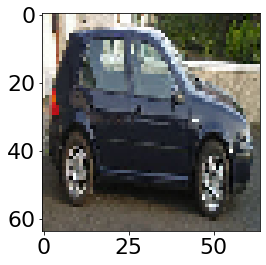

In [9]:
plt.imshow(Xbatch[4])

## Part 1: Training a convolutional neural network

Write a function `make_convnet` that builds a convolutional neural network.

The input shape should be `(img_size, img_size, 3)`, where `img_size` is the image size we defined above (such as 64), and 3 is for the red, green, and blue "channels" of the image. If you make use of the code we saw during the lecture, please note that this is a binary classification problem, so it's probably good to change the output layer and use another loss function.

Also remember to select a suitable optimizer.

In [10]:
epochs = 20
steps_per_epoch = len(train_generator)
validation_steps = len(validation_generator)

In [11]:
def make_convnet(img_width: int, img_height: int, channels: int) -> Model:
    # define model
    model = Sequential()
    
    # add convolutional layer with 32 convolution filters each with kernel size 3x3
    model.add(Conv2D(
        activation = "tanh",
        input_shape = (img_width, img_height, channels),
        filters = 96,
        kernel_size = (3, 3),
        strides = (1, 1),
    ))
    
    # add max-pooling layer to downsize input
    model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
    
    # add convolutional layer with 64 convolution filters each with kernel size 3x3
    model.add(Conv2D(activation = "relu", filters = 64, kernel_size = (3, 3)))
    
    # add max-pooling layer to downsize input
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    # add flatten layer to decrease the dimensions
    model.add(Flatten())
    
    # add dense layer to get fully connected and all relevant data
    model.add(Dense(activation = "relu", units = 128))
    
    # add dense layer
    model.add(Dropout(rate = 0.25, seed = 12345))
    
    # add dense layer as output layer with sigmoid activation function
    model.add(Dense(activation = "sigmoid", units = 1))

    # add the loss-function and compile
    model.compile(
        loss="binary_crossentropy",
        optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
        metrics = ["accuracy"],
    )

    return model

In [12]:
model = make_convnet(img_size, img_size, 3)

Before you can train the CNN, you need to make a second data generator for the generation of validation images. You should again use `data_gen.flow_from_directory`, but use the validation directory instead of the training directory.

In [13]:
# validation_generator = data_gen.flow_from_directory(
#         f"{imgdir}/validation", 
#         target_size = (img_size, img_size), 
#         batch_size = batch_size, 
#         class_mode = "binary", 
#         classes = ["other", "car"], 
#         seed = 12345, 
#         shuffle = True
# )

Now we have everything that we need to train the CNN. Call `fit` to train the model.

In most cases, training will be fairly time-consuming. The exact amount needed will depend on your machine, how you constructed your CNN, and how many epochs you let it train. Typically, training will take a few minutes.

In [14]:
fit_info = model.fit(
    train_generator,
    batch_size = batch_size,
    epochs = epochs,
    verbose = 2,
    validation_data = validation_generator,
    steps_per_epoch = steps_per_epoch, 
    validation_steps = validation_steps
)

Epoch 1/20
50/50 - 22s - loss: 0.6609 - accuracy: 0.5900 - val_loss: 0.6080 - val_accuracy: 0.6997 - 22s/epoch - 438ms/step
Epoch 2/20
50/50 - 19s - loss: 0.5771 - accuracy: 0.7044 - val_loss: 0.5642 - val_accuracy: 0.7118 - 19s/epoch - 389ms/step
Epoch 3/20
50/50 - 22s - loss: 0.5318 - accuracy: 0.7462 - val_loss: 0.5819 - val_accuracy: 0.7101 - 22s/epoch - 435ms/step
Epoch 4/20
50/50 - 20s - loss: 0.4913 - accuracy: 0.7688 - val_loss: 0.5129 - val_accuracy: 0.7708 - 20s/epoch - 392ms/step
Epoch 5/20
50/50 - 19s - loss: 0.4548 - accuracy: 0.8044 - val_loss: 0.5705 - val_accuracy: 0.7309 - 19s/epoch - 385ms/step
Epoch 6/20
50/50 - 22s - loss: 0.4213 - accuracy: 0.8213 - val_loss: 0.4967 - val_accuracy: 0.7674 - 22s/epoch - 434ms/step
Epoch 7/20
50/50 - 23s - loss: 0.4056 - accuracy: 0.8244 - val_loss: 0.5084 - val_accuracy: 0.7674 - 23s/epoch - 465ms/step
Epoch 8/20
50/50 - 21s - loss: 0.4057 - accuracy: 0.8269 - val_loss: 0.4765 - val_accuracy: 0.7899 - 21s/epoch - 426ms/step
Epoch 9/

Optionally, call `your_cnn.save_weights(some_file_name)` after training. This will save your weights to a file; you can recover them later using `your_cnn.load_weights(the_same_file_name)`, so that you can run your CNN several times without having to re-train every time.

In [15]:
model.save_weights("weights/model_weights_01")

**Hint**: Depending on how you build your CNN, you will see different accuracies. The dataset is balanced, so a majority-class dummy baseline would have an accuracy of 0.5. Let's hope you can get a better result than that. The validation set is a bit small because we don't have that much data, so you will probably see some fluctuation in the accuracy values.

Plot the training and validation loss for each epoch. Also plot the training and validation accuracies in another plot.

If you need to run the model on a dataset that you access via a generator, you can use `evaluate`. The loss function and the accuracy will be computed. (As you can see, these values are the same as you got in the last epoch when training.)

In [16]:
score = model.evaluate(
    validation_generator, 
    steps = validation_steps,
    verbose = 0
)

In [17]:
print(f"Test loss: {score[0]}, Test accuracy {score[1]}")

Test loss: 0.5223347544670105, Test accuracy 0.78125


### Training and Validation Loss for Each Epoch

In [18]:
def plot_losses(fit_info, epochs):
    
    # set plot figure size
    plt.figure(figsize = (20,10))
    
    # plot a line chart for training set loss
    plt.plot(
        list(range(1, epochs + 1)), 
        fit_info.history["loss"],
        color = "skyblue", 
        marker = "o", 
        markerfacecolor = "blue", 
        markersize = 16, 
        linewidth = 4
    )

    # plot a line chart for validation set loss
    plt.plot(
        list(range(1, epochs + 1)), 
        fit_info.history["val_loss"],
        color = "orange", 
        marker = "o", 
        markerfacecolor = "red", 
        markersize = 16, 
        linewidth = 4
    )

    # add plot title
    plt.title("Losses for Neural Network")
    
    # fix x-ticks
    xticks = list(range(1, epochs + 1, 2))
    plt.xticks(xticks)

    # fix y-ticks
    min_loss = min(fit_info.history["loss"] + fit_info.history["val_loss"])
    max_loss = max(fit_info.history["loss"] + fit_info.history["val_loss"])
    start_loss = 0.02 * (min_loss // 0.02)
    yticks = np.arange(start_loss, max_loss + 0.04, 0.05)
    plt.yticks(yticks)

    # add legend and labels
    plt.legend(["Training Set", "Validation Set"], loc = "lower right")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # show the plot
    plt.show()

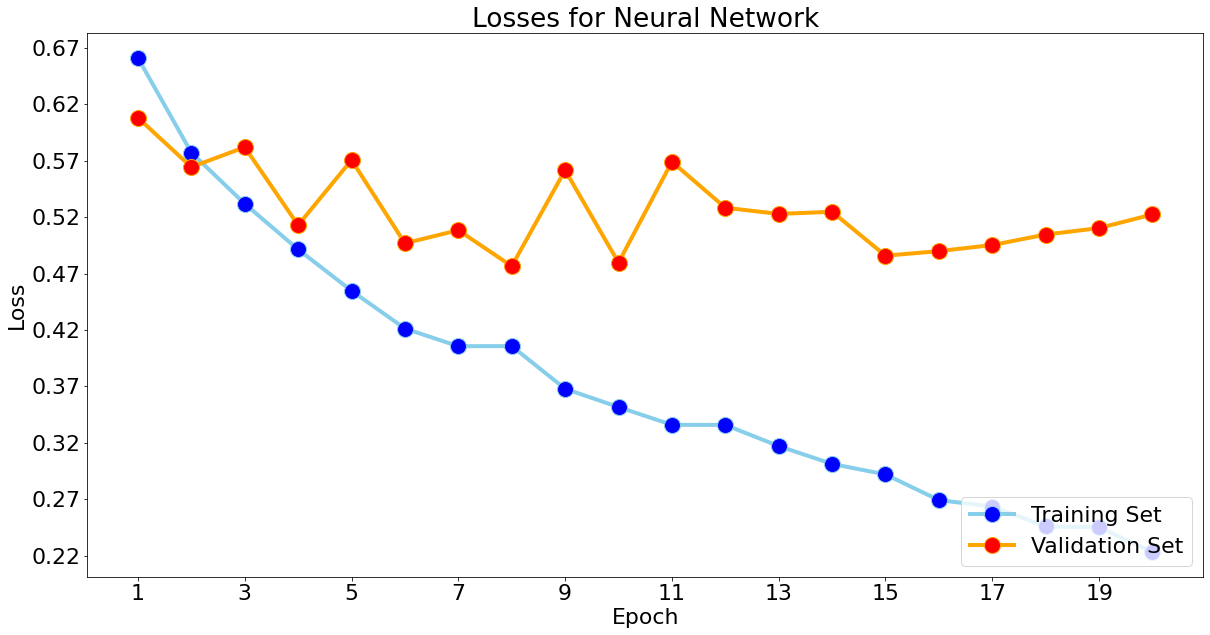

In [19]:
plot_losses(fit_info, epochs)

We can see a clear sign of overfitting when it comes to the loss. The validation loss decreases initially but steadily increases as the training loss keeps decreasing.

### Training and Validation Accuracy for Each Epoch

In [20]:
def plot_accuracies(fit_info, epochs):
    
    # set plot figure size
    plt.figure(figsize = (20,10))
    
    # plot a line chart for training set accuracy
    plt.plot(
        list(range(1, epochs + 1)), 
        [acc * 100 for acc in fit_info.history["accuracy"]],
        color = "skyblue", 
        marker = "o", 
        markerfacecolor = "blue", 
        markersize = 16, 
        linewidth = 4
    )

    # plot a line chart for validation set accuracy
    plt.plot(
        list(range(1, epochs + 1)), 
        [acc * 100 for acc in fit_info.history["val_accuracy"]],
        color = "orange", 
        marker = "o", 
        markerfacecolor = "red", 
        markersize = 16, 
        linewidth = 4
    )

    # add plot title
    plt.title("Accuracies for neural network")
    
    # fix x-ticks
    xticks = list(range(1, epochs + 1, 2))
    plt.xticks(xticks)

    # fix y-ticks
    min_acc = min(fit_info.history["accuracy"])
    start_acc = 0.02 * (min_acc // 0.02)
    yticks = np.arange(start_acc, 1.01, 0.02) * 100
    plt.yticks(yticks)

    # add legend and labels
    plt.legend(["Training Set", "Validation Set"], loc = "lower right")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy(%)")

    # show the plot
    plt.show()

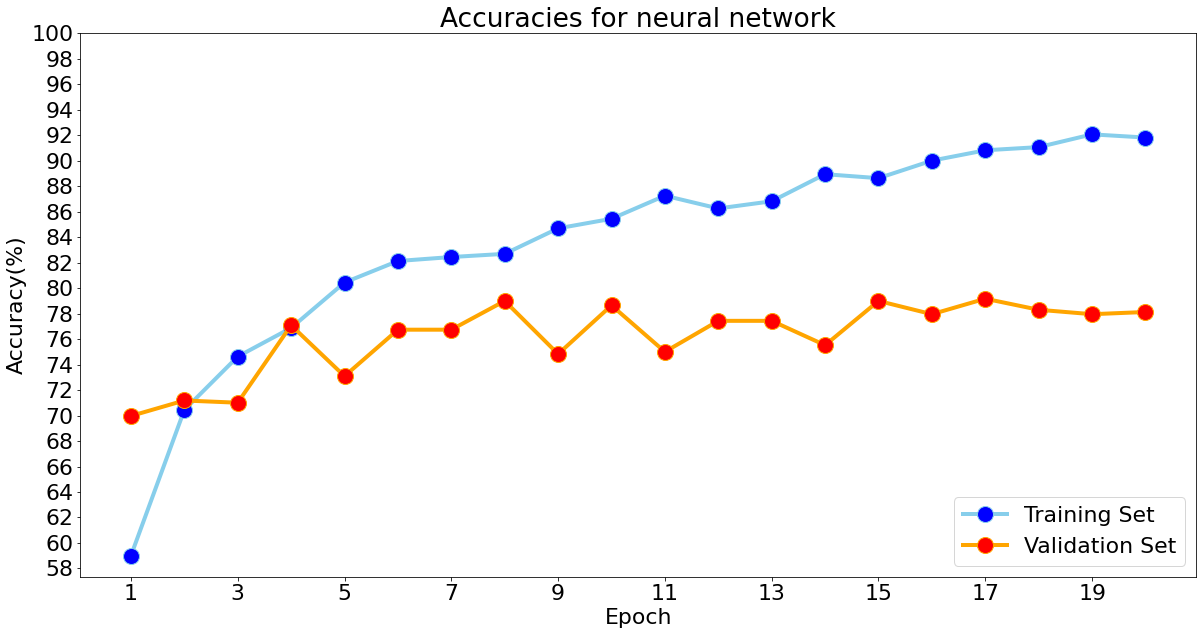

In [21]:
plot_accuracies(fit_info, epochs)

The same pattern can be seen with accuracy, although not as extreme. The validation accuracy seems to flatten. We can see a clear case of overfitting here. The training accuracy of the model increases and tends to 1, while the validation accuracy only improve during the first epochs, then quickly converges to 0.75 . This overfitting could have been avoided using fairly agressive early stopping, but the goal here is to highlight this overfitting.

## Part 2: Data augmentation

Most likely, unless you applied early stopping very aggressively, you saw some overfitting in your solution.

One approach to reducing the risk of overfitting to the training set is to apply data augmentation. This means that we create additional training instances by applying different types of modifications to the existing training images.

Take a look at the documentation of `ImageDataGenerator`. Several of the optional parameters enable different types of data augmentation, such as rotation, mirroring, and changing the colors.

![rotations](rotations.png)

Make a new `ImageDataGenerator` that applies data augmentation to the training images.

In [22]:
data_gen = ImageDataGenerator(
    rescale = 1.0 / 255, 
    shear_range = 0.2, 
    zoom_range = 0.2, 
    horizontal_flip = True, 
    vertical_flip = True
)

Make a new training data generator that uses the new `ImageDataGenerator`, instead of the generator `data_gen` we originally used, and retrain your model. (Note: The generator for reading the validation data should not use data augumentation.)

In [23]:
train_generator = data_gen.flow_from_directory(
    f"{imgdir}/train",
    target_size = (img_size, img_size),
    batch_size = batch_size,
    class_mode = "binary",
    classes = ["other", "car"],
    seed = 12345,
    shuffle = True
)

Found 1600 images belonging to 2 classes.


In [24]:
Xbatch, Ybatch = train_generator.next()

In [25]:
Xbatch.shape

(32, 64, 64, 3)

In [26]:
Ybatch[4]

1.0

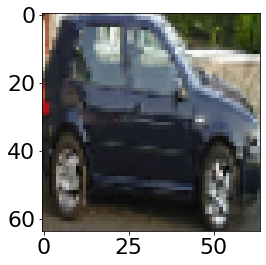

In [27]:
plt.imshow(Xbatch[4])

Do you see an improvement on the validation set?

**Hint**: If you play around with different types of data augmentation you will notice that there's a tradeoff between underfitting and overfitting. Typically, if you tune your augmentation carefully you will see a small improvement, but this will of course depend on how you built your CNN. Also, keep in mind that our validation set is tiny, so we see quite a bit of fluctuation in our evaluations. So even if the data augmentation has actually improved your classifier, it might be hard to discern the effect.

In [28]:
model = make_convnet(64, 64, 3)

In [29]:
fit_info = model.fit(
    train_generator,
    batch_size = batch_size,
    epochs = epochs,
    verbose = 2,
    validation_data = validation_generator,
    steps_per_epoch = steps_per_epoch, 
    validation_steps = validation_steps
)

Epoch 1/20
50/50 - 28s - loss: 0.6679 - accuracy: 0.5819 - val_loss: 0.6571 - val_accuracy: 0.6302 - 28s/epoch - 563ms/step
Epoch 2/20
50/50 - 24s - loss: 0.6102 - accuracy: 0.6794 - val_loss: 0.6025 - val_accuracy: 0.6858 - 24s/epoch - 472ms/step
Epoch 3/20
50/50 - 24s - loss: 0.5852 - accuracy: 0.7038 - val_loss: 0.5812 - val_accuracy: 0.6875 - 24s/epoch - 489ms/step
Epoch 4/20
50/50 - 24s - loss: 0.5536 - accuracy: 0.7431 - val_loss: 0.5587 - val_accuracy: 0.7292 - 24s/epoch - 484ms/step
Epoch 5/20
50/50 - 20s - loss: 0.5398 - accuracy: 0.7456 - val_loss: 0.5392 - val_accuracy: 0.7500 - 20s/epoch - 398ms/step
Epoch 6/20
50/50 - 23s - loss: 0.5394 - accuracy: 0.7394 - val_loss: 0.5341 - val_accuracy: 0.7465 - 23s/epoch - 451ms/step
Epoch 7/20
50/50 - 25s - loss: 0.5168 - accuracy: 0.7563 - val_loss: 0.5173 - val_accuracy: 0.7569 - 25s/epoch - 491ms/step
Epoch 8/20
50/50 - 24s - loss: 0.4967 - accuracy: 0.7644 - val_loss: 0.4990 - val_accuracy: 0.7639 - 24s/epoch - 482ms/step
Epoch 9/

In [30]:
model.save_weights("weights/model_weights_02")

In [31]:
score = model.evaluate(
    validation_generator, 
    steps = validation_steps,
    verbose = 0
)

In [32]:
print(f"Test loss: {score[0]}, Test accuracy {score[1]}")

Test loss: 0.475588321685791, Test accuracy 0.7777777910232544


Again, plot the losses and accuracies. Do you see any change?

### Training and Validation Loss for Each Epoch

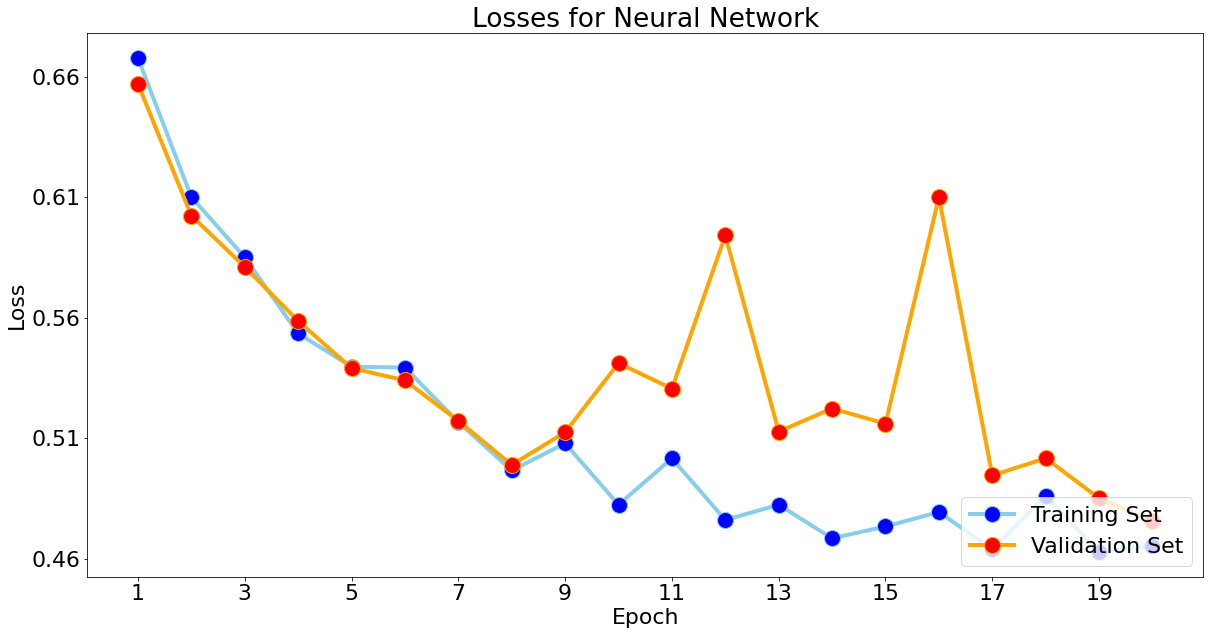

In [33]:
plot_losses(fit_info, epochs)

### Training and Validation Accuracy for Each Epoch

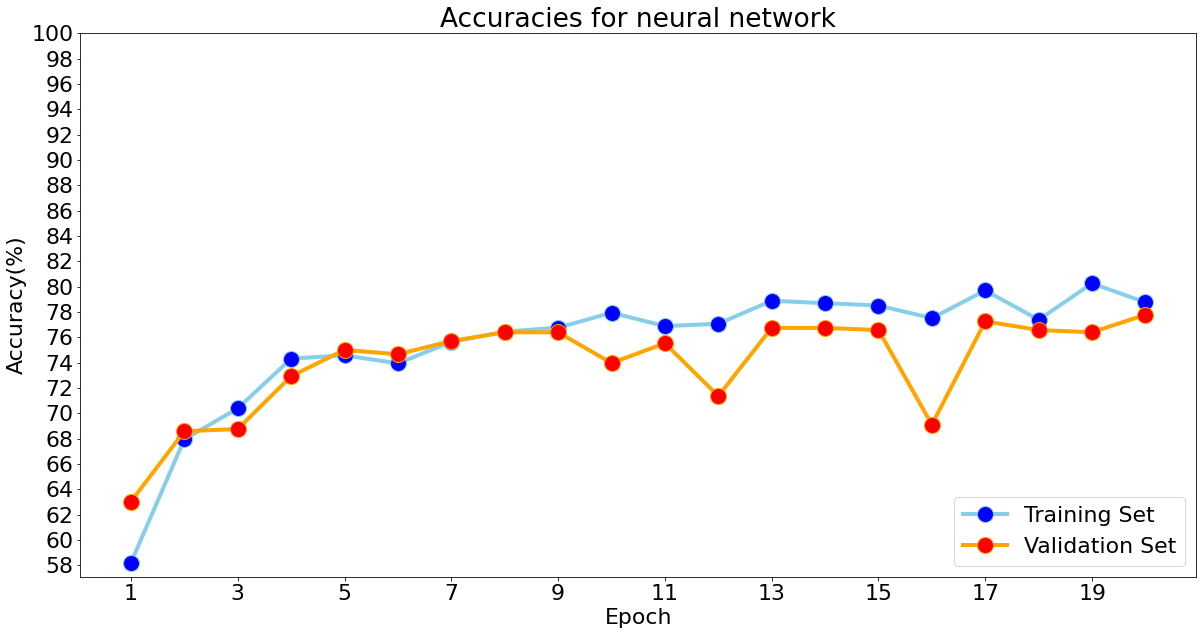

In [34]:
plot_accuracies(fit_info, epochs)

In this graph, the results from data augmentations are immediately visible. The validation accuracy is still at around 75% accuracy, but the overfitting of the training set is nowhere near as strong as when using the image data generator without data augmentation. We can also see that the validation accuracy is higher for most epochs.

## Interlude: Applying a pre-trained convolutional neural network

One of the most famous image databases used in computer vision is called [ImageNet](https://www.image-net.org/). It contains a very large number of categories and an even larger number of example images for each category. This is one of the standard benchmarks in the field.

Several CNNs that have been trained on ImageNet have been released to the public, and Keras includes several of them. In this exercise, we'll use the model called VGG-16, which was developed by a group at the university of Oxford. [Here](https://www.robots.ox.ac.uk/~vgg/research/very_deep/) is a description of VGG-16.

![VGG16 Figure](vgg16.png)

We use the built-in function in Keras to build the VGG-16 model and load the weights. Here, `weights='imagenet'` means that we use the pre-trained weights, and `include_top=True` that we use the full classification model.

The first time you execute this code, the VGG-16 model will be downloaded. (It will then be stored on your disk for future use.)

In [35]:
vggmodel = applications.VGG16(weights = "imagenet", include_top = True)

To demonstrate the VGG-16 model as a classifier, we will now classify an example image.

Carry out the following steps:

* Select any image, for instance one from your training or validation data. Take a look at the image so that you see what it depicts.
* Load the image using `load_img(the_file_name, target_size=(224,224))`. The 224x224 target size is required because this is the standard input size of the VGG-16 model when we use it as a classifier. This will return an `Image` object.
* Convert the image into a 3-dimensional NumPy array using `img_to_array`.
* Process the image using the Keras function `preprocess_input`. This function returns a new NumPy array. This step carries out some preprocessing of the image necessary for VGG-16. (This is different from dividing by 255 as we did previously.)
* Finally, reshape the image array into a four-dimensional array.

`your_image = your_image.reshape(1, 224, 224, 3)`

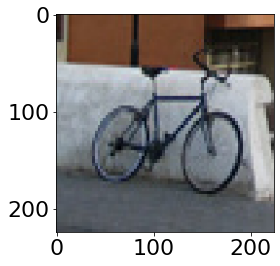

In [36]:
image = load_img(f'{imgdir}/train/other/0001.jpg', target_size = (224,224))
plt.imshow(image)

In [37]:
image_array = img_to_array(image)
image_array = preprocess_input(image_array)
image_array = image_array.reshape(1, 224, 224, 3)

The reason for reshaping is that the `predict` function in Keras operates on "batches" of images. Even if we are classifying just a single image, we need to put it into an array.

Predict the class probabilities for this image, using `vggmodel.predict`. This will result in a 1 x 1000 matrix. There are 1000 columns because the VGG-16 classifier uses 1000 ImageNet classes.

In [38]:
pred = vggmodel.predict(image_array)

1/1 [==============================] - 7s 7s/step


Apply the function `decode_prediction` to the output of the previous step. This will convert the probability matrix into human-readable ImageNet class labels. Does the prediction make sense?

In [39]:
decode_predictions(pred)

[[('n03792782', 'mountain_bike', 0.2712071),
  ('n04482393', 'tricycle', 0.17012039),
  ('n04509417', 'unicycle', 0.1312081),
  ('n02835271', 'bicycle-built-for-two', 0.052063838),
  ('n03785016', 'moped', 0.03745893)]]

Above are the VGG-16 model predictions. A bike was leaning against a wall as the input image. All of the VGG-16 projections seem to be tied to bikes somehow, which makes sense. It's difficult to tell what type of bike the image depicts, although it could very well be a mountain bike. 

## Part 3: Using VGG-16 as a feature extractor

Let's return to the problem of finding images of cars.

Since we just have 1,600 training images, the CNN we trained earlier wasn't fantastically successful. We'll now take a different approach, inspired by the paper by [Razavian et al. (2014)](http://openaccess.thecvf.com/content_cvpr_workshops_2014/W15/papers/Razavian_CNN_Features_Off-the-Shelf_2014_CVPR_paper.pdf): we'll use the VGG-16 model as a feature extractor: we'll apply the convolutional part of the VGG-16 model to our images, and use this output as the input of our own classifier. This solution is an example of **transfer learning**, which means that we leverage the knowledge stored in a pre-trained model and apply it to our specific task.

To get started, we load the VGG-16 model once more. Please note that the parameters are a bit different this time:

`include_top=False` because we won't use the highest layers in the ImageNet classifier. Instead, we'll train our own classifier.
We specify an `input_shape` that overrides the 224x224 size that is the default size used by VGG-16. For the purpose of comparing to our previous results, we'll use the same size as in our first CNN classifier.

In [40]:
feature_extractor = applications.VGG16(
    include_top=False, 
    weights='imagenet',
    input_shape=(img_size, img_size, 3)
)

Before reading the images, we need to create a new `ImageDataGenerator` that applies `preprocess_input` (the preprocessing required for VGG-16) to the images that it processes.

In [41]:
vgg_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input)

Now, write a function `create_vgg16_features` that carries out the following steps:

* First, make a generator that reads a given directory (either the train or the validation directory). You should use `vgg_data_gen`, so that the preprocessing is done correctly. [**Hint**: for reasons that will become clearer a bit later, if you set shuffle=False in the generator, you will make your life easier later on.]
* Second, apply the VGG-16 model to the generator (`feature_extractor.predict(...)`). This will return a four-dimensional NumPy array.
* Third, save this NumPy array into a file.

    ```python
    with open(SOME_FILE_NAME, 'wb') as f:
        np.save(f, cnn_features)
    ```

Make sure that you don't use the same file name for the training part and the validation part. The `'wb'` option means that we are writing the data into a binary format, not a text format.

In [42]:
def create_vgg16_features(dir , file_name):
    generator = vgg_data_gen.flow_from_directory(
        imgdir + dir,
        target_size = (img_size, img_size),
        batch_size = batch_size,
        class_mode = "binary",
        classes = ["other", "car"],
        seed = 12345,
        shuffle = False
    )
    
    cnn_features = feature_extractor.predict(generator)
    
    with open(file_name, "wb") as f:
        np.save(f, cnn_features)

Call this function twice, once for the training part and once for the validation part. This process should take a few minutes, depending on the performance of your machine.

In [43]:
# creating training features and saving to vgg16_train.txt
create_vgg16_features("/train","vgg16_train.txt")

Found 1600 images belonging to 2 classes.
50/50 [==============================] - 40s 768ms/step


In [44]:
# creating validation features and saving to vgg16_val.txt
create_vgg16_features("/validation","vgg16_val.txt")

Found 576 images belonging to 2 classes.
18/18 [==============================] - 13s 745ms/step


Finally, write a function `train_on_cnnfeatures` that reads the two files that you created, trains a classifier on the training set, and evaluates on the validation set. To read the files, you can write something like this:

```python
with open(SOME_FILE_NAME, 'rb') as f:
    the_data = np.load(f)
```

Here, `'rb'` means that we are reading in a binary format.

You can use Keras or scikit-learn to train this classifier. But

* If you use Keras, your first layer needs to be a `Flatten` layer, to convert the outputs from the last VGG-16 pooling layer into straight vectors.
* If you use scikit-learn, you need to `reshape` the data appropriately, so that it becomes a two-dimensional NumPy matrix.
  
To keep things simple, the following helper function may be used to create the output labels, assuming that the dataset has a size of `n`. This function assumes that all the `other` instances come before the `car` instances. (This is the reason we set `shuffle=False` in the generator above.)

In [45]:
def get_labels(n):
    return np.array([0]*(n//2) + [1]*(n//2))

In [46]:
def define_model(img_width: int, img_height: int, channels: int) -> Model:
    # define model
    model = Sequential()

    # add flatten layer to decrease the dimensions
    model.add(Flatten())
    
    # add dense layer to get fully connected and all relevant data
    model.add(Dense(activation = "relu", units = 128))
    
    # add dense layer to get fully connected and all relevant data
    model.add(Dense(activation = "sigmoid", units = 1))

    # add the loss-function and compile
    opt = optimizers.SGD(learning_rate = 0.001, momentum = 0.9)
    model.compile(
        optimizer = opt, 
        loss = "binary_crossentropy", 
        metrics = ["accuracy"]
    )
    
    return model

In [47]:
# Function that loads the training and valdiation data and trains the new cnn classifier
def train_on_cnnfeatures():
    
    with open('vgg16_train.txt','rb') as f:
        train = np.load(f)

    with open('vgg16_val.txt','rb') as f:
        validation = np.load(f)

    train_labels = get_labels(len(train))
    validation_labels = get_labels(len(validation))

    model = define_model(img_size, img_size, 3)

    return model, model.fit(
        train, 
        train_labels, 
        batch_size = batch_size, 
        epochs = epochs, 
        verbose = 1, 
        validation_data = (validation, validation_labels)
    )

In [48]:
model, fit_info = train_on_cnnfeatures()

Epoch 1/20
50/50 [==============================] - 3s 17ms/step - loss: 1.6538 - accuracy: 0.8556 - val_loss: 0.5440 - val_accuracy: 0.8420
Epoch 2/20
50/50 [==============================] - 0s 5ms/step - loss: 0.1801 - accuracy: 0.9400 - val_loss: 0.3945 - val_accuracy: 0.8854
Epoch 3/20
50/50 [==============================] - 0s 6ms/step - loss: 0.0473 - accuracy: 0.9869 - val_loss: 0.4117 - val_accuracy: 0.8819
Epoch 4/20
50/50 [==============================] - 0s 6ms/step - loss: 0.0218 - accuracy: 0.9969 - val_loss: 0.4286 - val_accuracy: 0.8802
Epoch 5/20
50/50 [==============================] - 0s 7ms/step - loss: 0.0106 - accuracy: 0.9987 - val_loss: 0.4398 - val_accuracy: 0.8837
Epoch 6/20
50/50 [==============================] - 0s 5ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.4813 - val_accuracy: 0.8837
Epoch 7/20
50/50 [==============================] - 0s 5ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.4813 - val_accuracy: 0.8767
Epoch 8/20
50/50 [=

In [49]:
model.save_weights("weights/model_weights_03")

What is your accuracy this time? If the accuracy is different from when you trained your previous CNN, what do you think is the reason for the difference?

**Hint**: If you have solved this task correctly, you are likely to see an accuracy that is significantly higher than when you trained your standalone CNN previously.

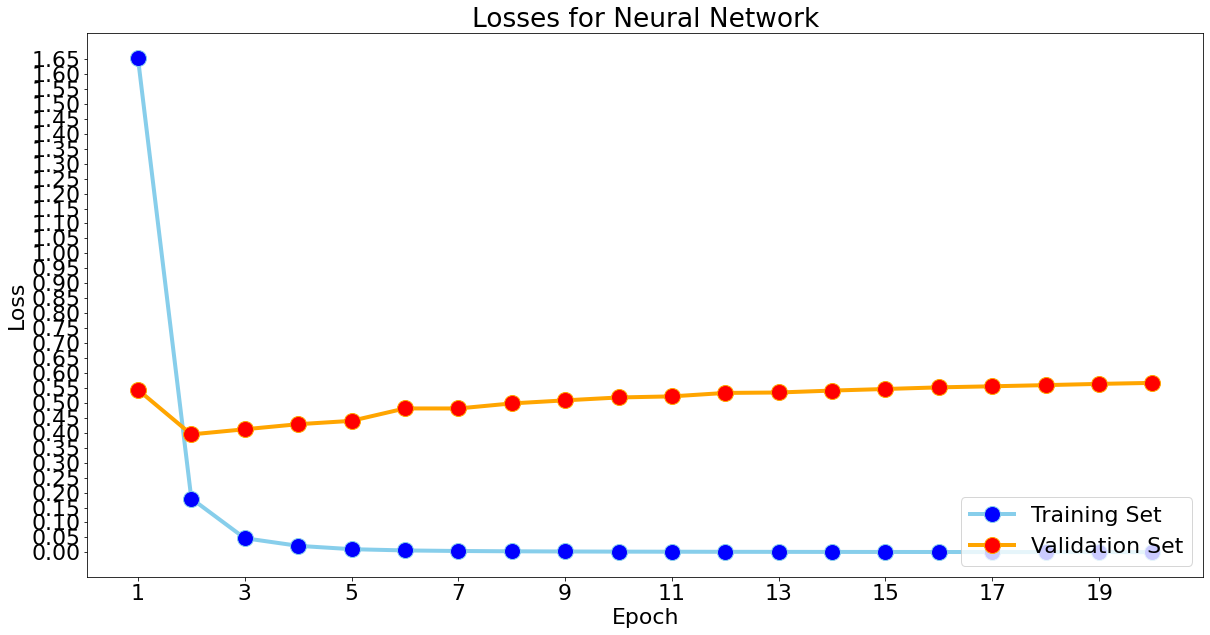

In [52]:
plot_losses(fit_info, epochs)

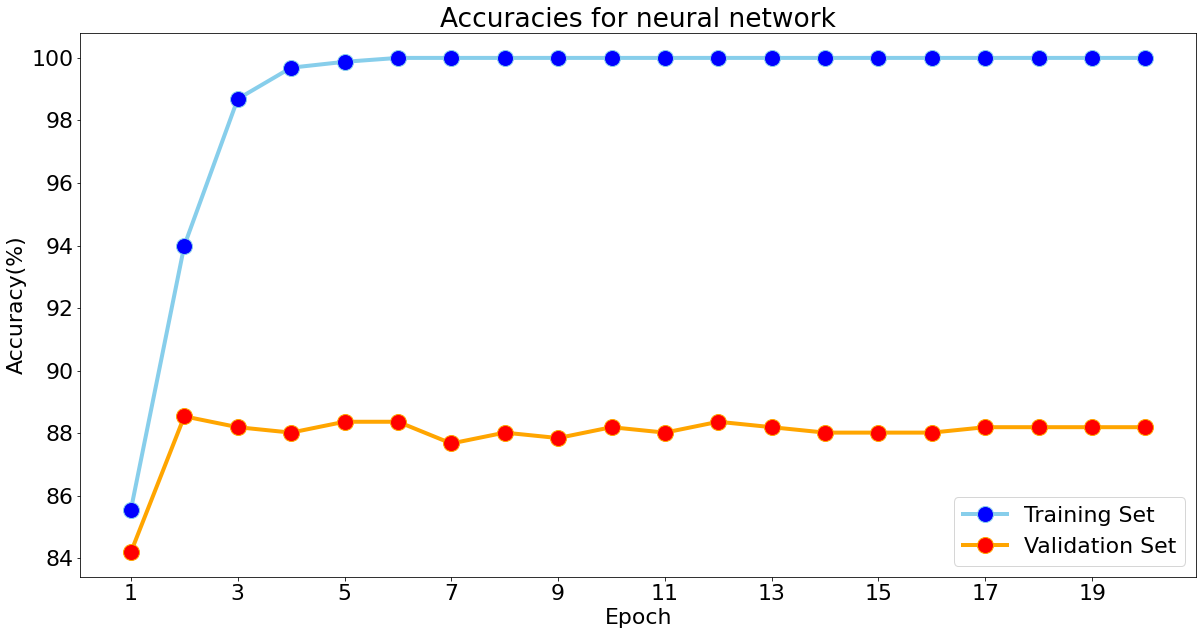

In [53]:
plot_accuracies(fit_info, epochs)

We got a significantly higher validation accuracy than the CNN in part 2. We believe that this difference is that the model is now analyzing picture features (metadata of the picture generated by the VGG model) instead of pixels. There is probably a lot more helpful information for the neural network from data stating that the picture probably contains an ambulance or a fire truck than data from just a pixel. The neural network learns that some picture features, which describe words generated by the VGG model, are more likely to be connected to one of the labels (car or other), which helps it analyze the picture. The difference between computing on describing words or pixels as features is that words are more discrete and that if the feature 'fire truck' shows up on two different pictures, they are likely to contain similar objects. In contrast, two similar pixels might contain two completely different objects, which is why it is easier to find patterns in words than in pixels.

The accuracy this time is around 88%, which is a lot better than the results we got from our CNN previously, which is almost certainly because our CNN was unable to extract the features from the images. We used the same neural network on the features we previously used in our model after convolution and pooling, which shows that the CNN part of our previous model was the weak link.

## Part 4: Visualizing the learned features

The first convolutional layer represents the most low-level patterns that the model looks for in images. We will now visualize these features in the VGG-16 model. (You can also repeat the exercise using your own original model, but because we have so little data, the features in this model may look less like interpretable patterns.)

We get the weights in this convolutional layer. This is a four-dimensional NumPy tensor: width x height x colors x number of convolutions.

In [54]:
first_layer_weights = vggmodel.get_weights()[0]
first_layer_weights.shape

(3, 3, 3, 64)

We create a utility function that will help us visualize the patterns extracted by the first convolutional layer.

This function takes three inputs: the layer's weight tensor (from the step above), a number referring to which convolutional filter we are considering (0-63), and finally a boolean (`True/False`) value that says whether we want to see the positive or the negative part of this filter. (That is, if `positive=True`, we see the patterns which enable this "feature"; if it is `False`, we see the patterns that disable it.)

In [55]:
def kernel_image(weights, i, positive):
    
    # extract the convolutional kernel at position i
    k = weights[:, :, :, i].copy()
    if not positive:
        k = -k
    
    # clip the values: if we're looking for positive
    # values, just keep the positive part; vice versa
    # for the negative values.
    k *= k > 0

    # rescale the colors, to make the images less dark
    m = k.max()
    if m > 1e-3:
        k /= m 

    return k

Finally, visualize some of the patterns used by the first convolutional layer. It can be useful to show these images in pairs, so that for each convolutional filter you see the positive and negative pattern.

In [56]:
positive_kernel_images = [kernel_image(first_layer_weights, x, True) for x in range(64)]
negative_kernel_images = [kernel_image(first_layer_weights, x, False) for x in range(64)]

FILTER No.0


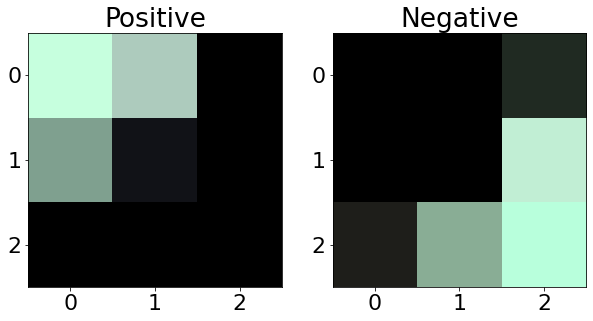

FILTER No.8


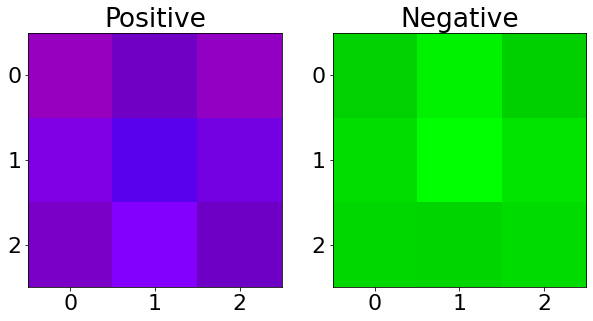

FILTER No.16


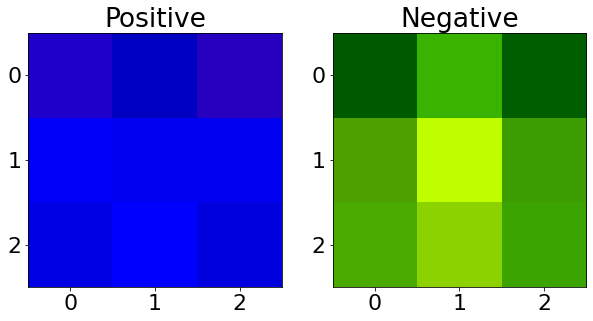

FILTER No.24


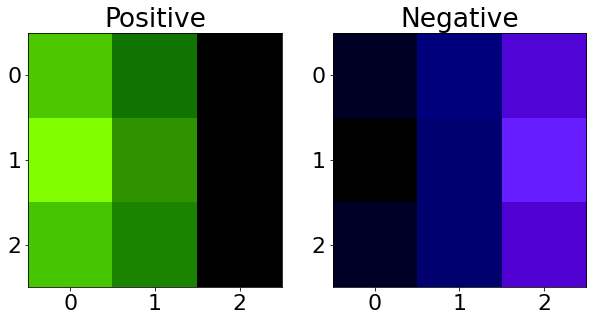

FILTER No.32


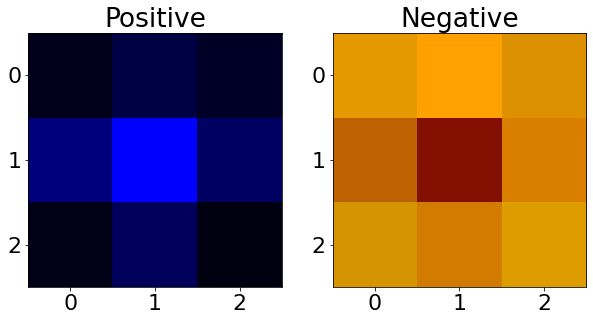

FILTER No.40


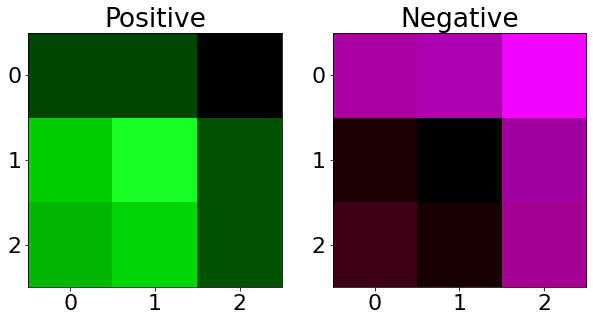

FILTER No.48


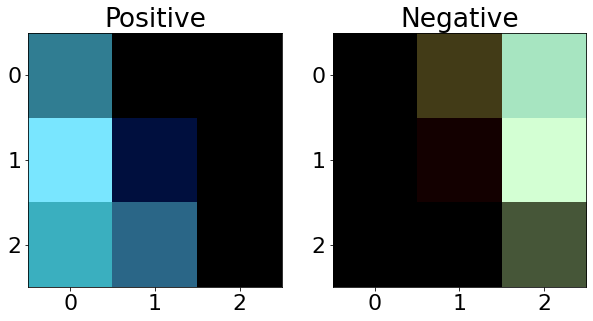

FILTER No.56


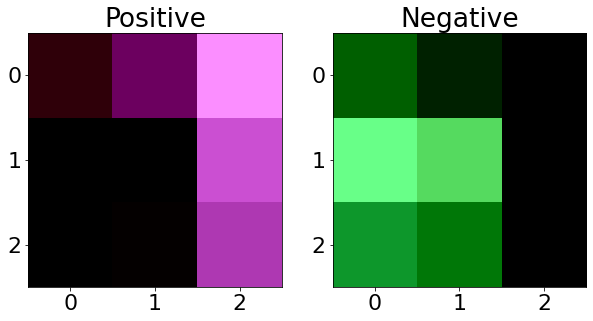

In [60]:
plt.style.use('seaborn-bright')
for i in range(0, len(positive_kernel_images), 8):
    
    print((f"FILTER No.{i}"))
    
    # define figure with sublots
    fig, axs = plt.subplots(1, 2, figsize = (10,10))

    # plot for positive kernel images and add title
    axs[0].imshow(positive_kernel_images[i])
    axs[0].set_title("Positive")

    # plot for negative kernel images and add title
    axs[1].imshow(negative_kernel_images[i])
    axs[1].set_title("Negative")

    # show plot
    plt.show()